# FRE7841 Hedge Fund Strategies: Final Project Fall 2025

Team members:

- Joaquin Garay
- Juan Camilo Meneses
- Charles Wu

December 6th, 2025

# Carry-trend strategy on US SOFR Forward Swap Curve using PCA

## General description

Our strategy aims to generate P&L from carry in the US SOFR Forward Swap yield curve. The strategy aims to be neutral to level shifts in the yield curve, and benefit from rolling across the slope of the curve (forward or spot), based on long-run deviations from mean level.

### Data

We use daily constant maturity SOFR swap rates from Jan 31st, 2021- October 31st to construct our PCA analysis,

### Strategy setp-up

The next steps ddescribe our approach:



1.   Data
2.   List item

# PCA Analysis


In [567]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import module_joaquin as mod

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [568]:
spot_df = pd.read_csv("data/spot_sofr.csv",
                      parse_dates=["Dates"], header=0)
spot_df = spot_df.set_index("Dates")
spot_df = spot_df.apply(pd.to_numeric, errors="coerce").dropna()

In [569]:
spot_df.describe()

,1W,2W,3W,1M,2M,3M,4M,5M,6M,7M,...,6Y,7Y,8Y,9Y,10Y,12Y,15Y,20Y,25Y,30Y
count,1227.000000,1227.000000,1227.000000,1227.000000,1227.000000,1227.000000,1227.000000,1227.000000,1227.000000,1227.000000,...,1227.000000,1227.000000,1227.000000,1227.000000,1227.000000,1227.000000,1227.000000,1227.000000,1227.000000,1227.000000
mean,3.210562,3.220562,3.230065,3.243079,3.279712,3.308236,3.327507,3.339513,3.346153,3.348048,...,2.945602,2.959370,2.975515,2.993796,3.013269,3.053087,3.095573,3.103757,3.048649,2.981810
std,2.157385,2.154040,2.150757,2.147080,2.131827,2.115456,2.097432,2.079721,2.061706,2.043166,...,1.221321,1.171626,1.134854,1.107488,1.086337,1.057026,1.032667,1.000465,0.967539,0.937377
min,0.004000,0.006800,0.007900,0.011000,0.011000,0.014300,0.018500,0.018950,0.021100,0.024550,...,0.334700,0.438650,0.531750,0.618000,0.693650,0.822350,0.947250,1.066250,1.117000,1.145350
25%,0.285520,0.296340,0.300700,0.302125,0.411600,0.519550,0.644950,0.757750,0.845125,0.937250,...,1.976375,1.982000,1.989175,1.996500,2.009000,2.041350,2.072800,2.088350,2.028300,1.970275
50%,4.315800,4.317100,4.318300,4.320200,4.317340,4.305500,4.287220,4.272200,4.251150,4.219860,...,3.462350,3.466500,3.470500,3.479000,3.492500,3.485450,3.486850,3.447600,3.347000,3.241070
75%,5.066900,5.087850,5.119655,5.141250,5.180975,5.139125,5.180325,5.145050,5.125050,5.080510,...,3.835510,3.816325,3.807700,3.819100,3.839600,3.871410,3.916150,3.920650,3.858150,3.784300
max,5.367000,5.356500,5.358600,5.364000,5.382000,5.422500,5.457900,5.485250,5.500450,5.511850,...,4.673850,4.660000,4.651750,4.649900,4.651100,4.659000,4.665800,4.615500,4.506500,4.395250


In [570]:
from sklearn.decomposition import PCA

spot_diff = spot_df.diff(1).dropna()
n_mats = len(spot_diff.columns)

pca = PCA(n_components=n_mats).fit(spot_diff)
explained_variance = pca.explained_variance_ratio_

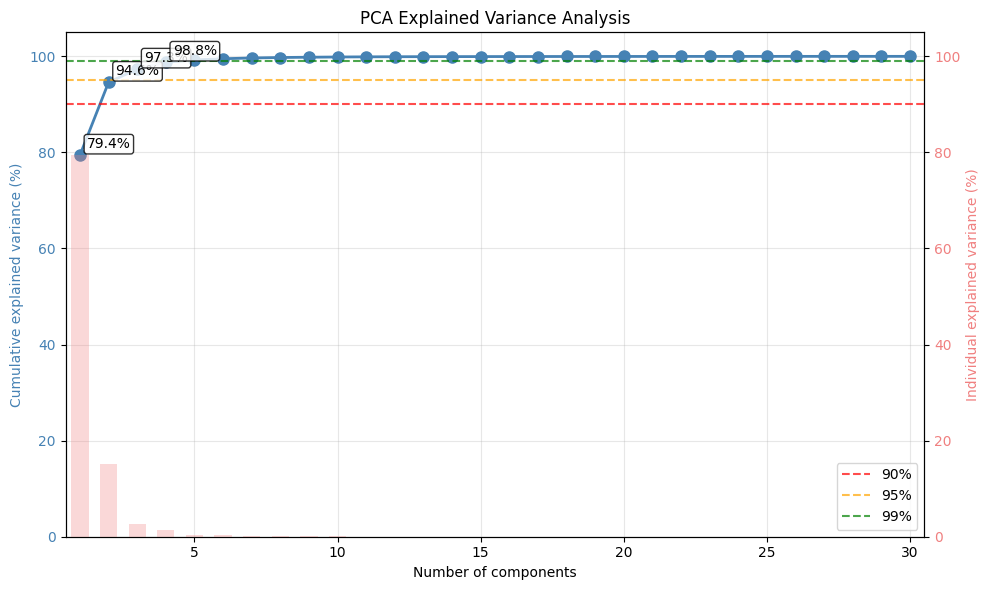

In [571]:
fig, ax = plt.subplots(figsize=(10, 6))

# plot cumulative explained variance with better styling
ax.plot(
    range(1, n_mats + 1),
    100 * explained_variance.cumsum(),
    "o-",
    linewidth=2,
    markersize=8,
    color="steelblue",
)

# add individual explained variance as bars
ax2 = ax.twinx()
ax2.bar(
    range(1, n_mats + 1),
    100 * explained_variance,
    alpha=0.3,
    color="lightcoral",
    width=0.6,
    label="Individual",
)

# add horizontal reference lines
ax.axhline(y=90, color="red", linestyle="--", alpha=0.7, label="90%")
ax.axhline(y=95, color="orange", linestyle="--", alpha=0.7, label="95%")
ax.axhline(y=99, color="green", linestyle="--", alpha=0.7, label="99%")

# annotations for first few components
for i in range(min(4, n_mats)):
    cumvar = 100 * explained_variance[: i + 1].sum()
    ax.annotate(
        f"{cumvar:.1f}%",
        xy=(i + 1, cumvar),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=10,
        bbox={"boxstyle": "round,pad=0.2", "facecolor": "white", "alpha": 0.8},
    )

# styling
ax.set_xlabel("Number of components")
ax.set_ylabel("Cumulative explained variance (%)", color="steelblue")
ax2.set_ylabel("Individual explained variance (%)", color="lightcoral")
ax.set_title("PCA Explained Variance Analysis")
ax.grid(True, alpha=0.3)
ax.legend(loc="lower right")
ax.set_xlim(0.5, n_mats + 0.5)
ax.set_ylim(0, 105)
ax2.set_ylim(0, 105)

# color the y-axis labels to match the data
ax.tick_params(axis="y", labelcolor="steelblue")
ax2.tick_params(axis="y", labelcolor="lightcoral")

plt.tight_layout()
plt.show()

### PCA on the differences

In [572]:
spot_diff = spot_df.diff(1).dropna()
n_mats = len(spot_diff.columns)
n_obs = len(spot_diff)
window_size = 252

scores_diff, daily_pca_diff = mod.rolling_pca(df=spot_diff,
                                       window_size=window_size,
                                       recalibration_period=1,
                                       columns=None,
                                       )

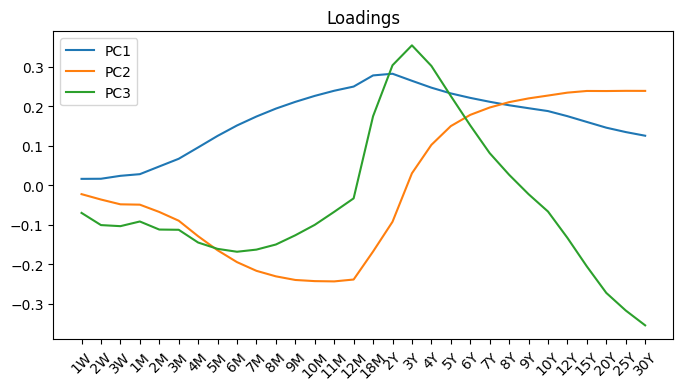

In [573]:
plt.figure(figsize=(8, 4))
plt.plot(daily_pca_diff["2024-01-04"]["loadings"].T)
plt.xticks(range(len(spot_df.columns)),
           labels=spot_df.columns.to_list(),
           rotation=45)
plt.title("Loadings")
plt.legend(["PC1", "PC2", "PC3"])
plt.show()



In [574]:
daily_pca_diff["2022-01-04"]["explained_var_ratio"]

array([0.89115865, 0.08066351, 0.01703509])

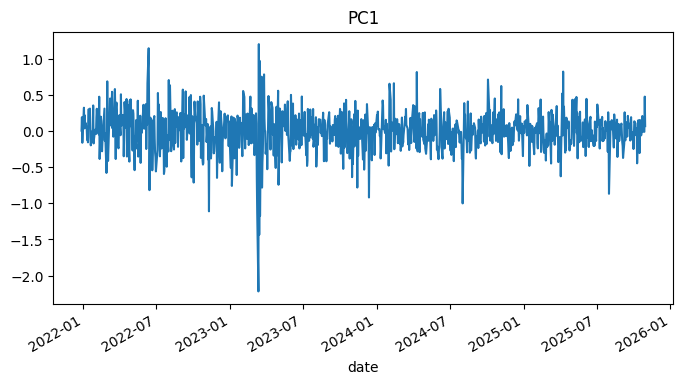

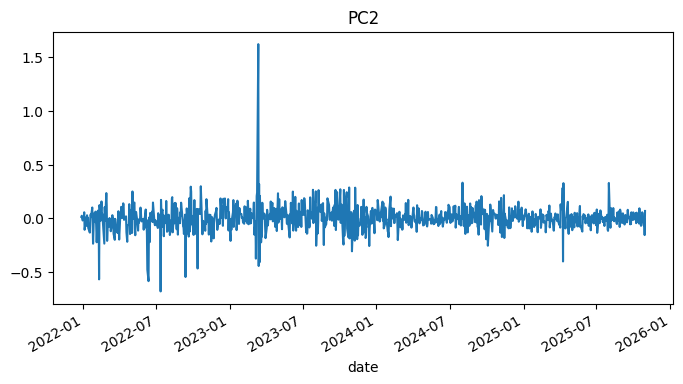

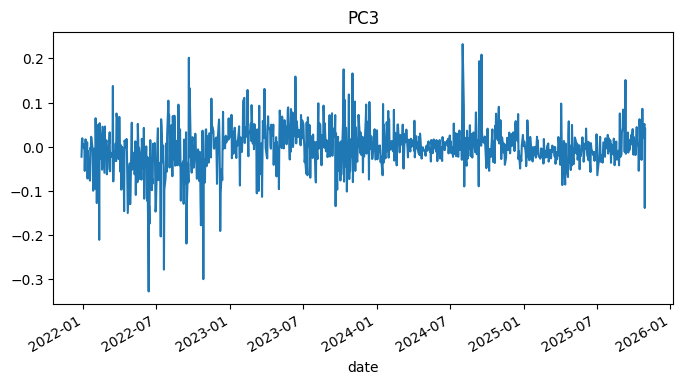

In [575]:
for i in range(1, 4):
    scores_diff[f"PC{i}"].plot(title=f"PC{i}", figsize=(8,4))
    plt.show()

### PCA on the levels

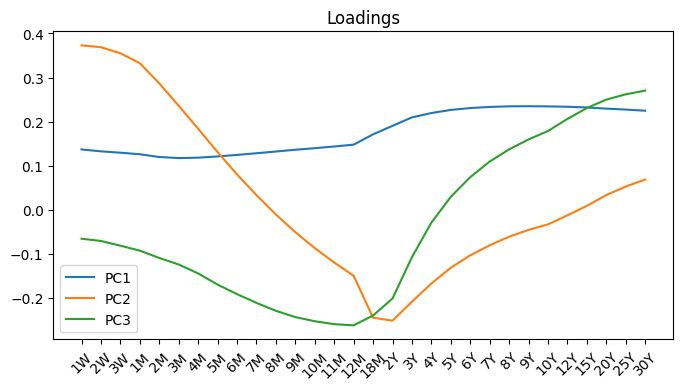

In [576]:
n_mats = len(spot_diff.columns)
n_obs = len(spot_diff)
window_size = 252

scores, daily_pca = mod.rolling_pca(df=spot_df,
                                       window_size=window_size,
                                       recalibration_period=1,
                                       columns=None,
                                       )

plt.figure(figsize=(8, 4))
plt.plot(daily_pca["2024-01-04"]["loadings"].T)
plt.xticks(range(len(spot_df.columns)),
           labels=spot_df.columns.to_list(),
           rotation=45)
plt.title("Loadings")
plt.legend(["PC1", "PC2", "PC3"])
plt.show()

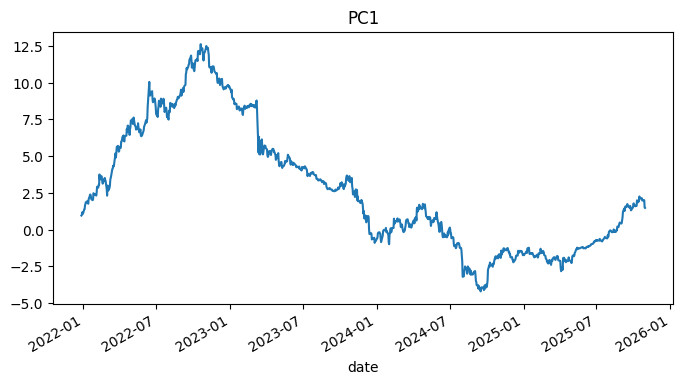

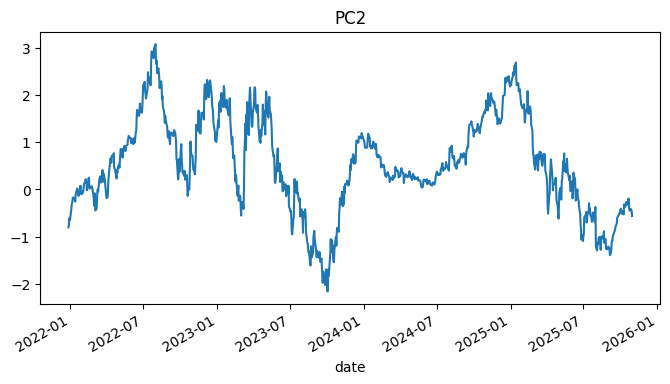

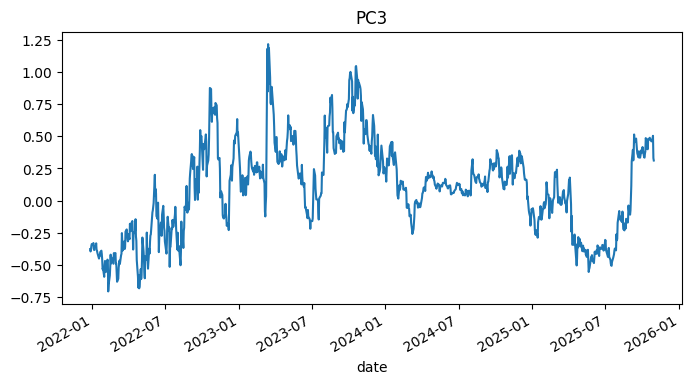

In [577]:
for i in range(1, 4):
    scores[f"PC{i}"].plot(title=f"PC{i}", figsize=(8,4))
    plt.show()